# Import necessary modules

In [1]:
import librosa  # for audio processing
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile  # for audio processing
from numpy.lib.stride_tricks import as_strided
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Audio
import sklearn
import pandas as pd
import json
import os
from os.path import exists
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../scripts')
from audio_trans_loader import AudioLoader
from Audio_visualization import AudioVis
from audio_augment import AugmentAudio
# from cleaner import CleanDataFrame

In [2]:
# Create cleaner module and plotter module classes
loader = AudioLoader()
visualizer = AudioVis()
augment = AugmentAudio()

# Variables for data paths 

In [3]:
train_dataset_location = 'train/'
train_wav_location = os.path.join(train_dataset_location, 'wav/')
train_changed_wav_location = os.path.join(train_dataset_location, 'changed_wav/')
train_txt_location = os.path.join(train_dataset_location, 'trsTrain.txt')
test_dataset_location = 'test/' 
lexicon_location = 'train/'

In [4]:
# %cd drive/MyDrive/Week-4-STT/data/AMHARIC/data/
%cd ../data/

c:\Users\User\Desktop\10AcademyProjects\speech-to-text\Speech-to-Text\data


# Load Train Data and Transcription File

In [5]:
train_file_names = os.listdir(train_wav_location)
train_wav_paths = [ os.path.join(train_wav_location, file_name)
                    for file_name in train_file_names]
print(f"We have {len(train_wav_paths)} Amharic wav files in the training set")

We have 8119 Amharic wav files in the training set


In [6]:
transcription = loader.loaderTrans(train_txt_location)

# Change Mono Channel To Stereo

In [7]:
import wave, array
def change_channel_to_stereo(file1, output):
    try:
        ifile = wave.open(file1)
        print(ifile.getparams())
        # (1, 2, 44100, 2013900, 'NONE', 'not compressed')
        (nchannels, sampwidth, framerate, nframes, comptype, compname) = ifile.getparams()
        assert comptype == 'NONE'  # Compressed not supported yet
        array_type = {1:'B', 2: 'h', 4: 'l'}[sampwidth]
        left_channel = array.array(array_type, ifile.readframes(nframes))[::nchannels]
        ifile.close()

        stereo = 2 * left_channel
        stereo[0::2] = stereo[1::2] = left_channel

        ofile = wave.open(output, 'w')
        ofile.setparams((2, sampwidth, framerate, nframes, comptype, compname))
        print(ofile.getnchannels())
        ofile.writeframes(stereo.tobytes())
        ofile.close()
        return ofile.getnchannels()
    except Exception as e:
        print(e)

# Resize audio to a fixed size

In [8]:
def resize_audio(audio: np.array, size: int) -> np.array:
        """
        This resizes all input audio to a fixed sample size.
        It helps us to have a consistent data shape

        Args:
            audio: This is the audio sample as a numpy array
        """
        resized = librosa.util.fix_length(audio, size, axis=1)
        print(f"Audio resized to {size} samples")
        return resized

In [9]:
# we will use the first wav file to visualize its characteristics
#librosa load returns by default time-series as numpy array and with the default sample rate of 22KHZ so we just changed it to 44kHZ
samples, sample_rate = librosa.load(train_wav_location+'tr_1_tr01001.wav' , sr=44100)
print(samples)
print(sample_rate)

[-0.00502738 -0.00588078 -0.00577551 ... -0.00516981 -0.00347923
  0.        ]
44100


In [10]:
# Change 10 mono files for demo
for file_name in train_file_names[0:10]:
    loader.change_channel_to_stereo(os.path.join(train_wav_location, file_name) , os.path.join(train_changed_wav_location, file_name))
        

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=90112, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=98304, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=86016, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=106496, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=104448, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=88064, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=71680, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=77824, comptype='NONE', compname='not compressed')
2
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframe

# Data Visualization

In [11]:
ipd.Audio(samples, rate=sample_rate)

# Plot of the Audio Array

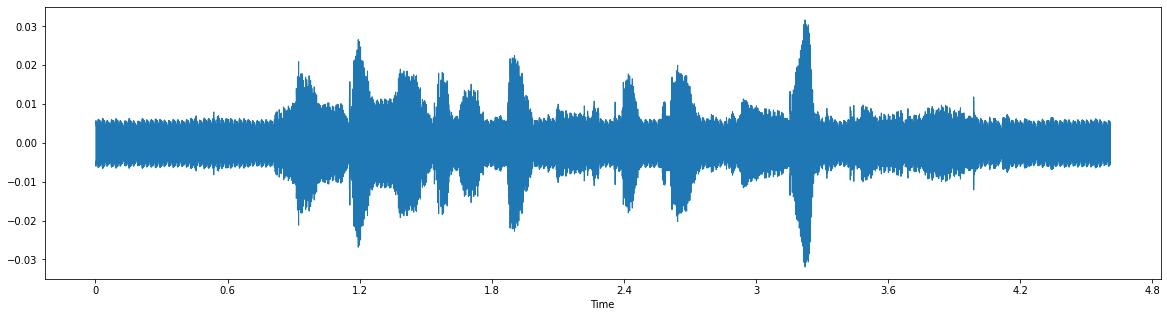

In [12]:
# Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(samples, sr=sample_rate)
plt.show()

# Plot of spectogram of the audio 
    - Convert time domain into frequency domain

In [13]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

spe_samples, frequency = loader.spectrogram(samples)
print(frequency)
print(spe_samples)

[0.        0.0078125 0.015625  0.0234375 0.03125   0.0390625 0.046875
 0.0546875 0.0625    0.0703125 0.078125  0.0859375 0.09375   0.1015625
 0.109375  0.1171875 0.125     0.1328125 0.140625  0.1484375 0.15625
 0.1640625 0.171875  0.1796875 0.1875    0.1953125 0.203125  0.2109375
 0.21875   0.2265625 0.234375  0.2421875 0.25      0.2578125 0.265625
 0.2734375 0.28125   0.2890625 0.296875  0.3046875 0.3125    0.3203125
 0.328125  0.3359375 0.34375   0.3515625 0.359375  0.3671875 0.375
 0.3828125 0.390625  0.3984375 0.40625   0.4140625 0.421875  0.4296875
 0.4375    0.4453125 0.453125  0.4609375 0.46875   0.4765625 0.484375
 0.4921875 0.5       0.5078125 0.515625  0.5234375 0.53125   0.5390625
 0.546875  0.5546875 0.5625    0.5703125 0.578125  0.5859375 0.59375
 0.6015625 0.609375  0.6171875 0.625     0.6328125 0.640625  0.6484375
 0.65625   0.6640625 0.671875  0.6796875 0.6875    0.6953125 0.703125
 0.7109375 0.71875   0.7265625 0.734375  0.7421875 0.75      0.7578125
 0.765625  0.77343

In [14]:
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    # plt.savefig('spectogramfeature.png')

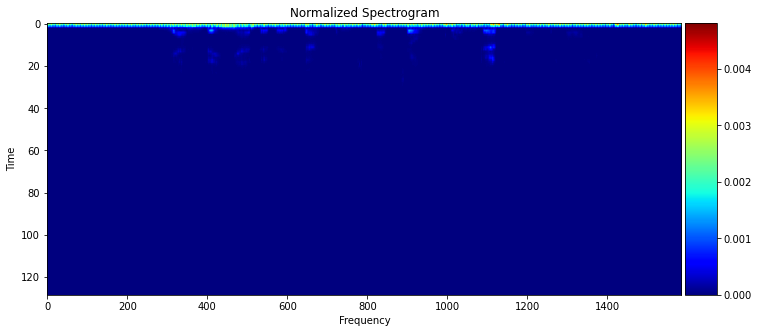

In [15]:
visualizer.plot_spectrogram_feature(spe_samples)

# Plot STFT
    - STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows as shown below

    - Using STFT we can determine the amplitude of various frequencies playing at a given time of an audio signal

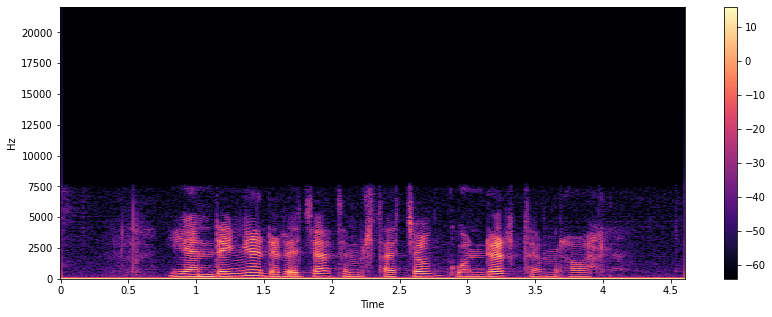

In [16]:
# X = librosa.stft(samples)
# Xdb = librosa.amplitude_to_db(abs(X))
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
# plt.colorbar()
# plt.show()
# plt.savefig('specshow.png')
visualizer.plot_stft(samples,sample_rate)

# Plot the spectral Centroid

In [17]:
spectral_centroids = librosa.feature.spectral_centroid(
    samples, sr=sample_rate)[0]

spectral_centroids.shape

(397,)

In [18]:
# # Computing the time variable for visualization
# plt.figure(figsize=(12, 4))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

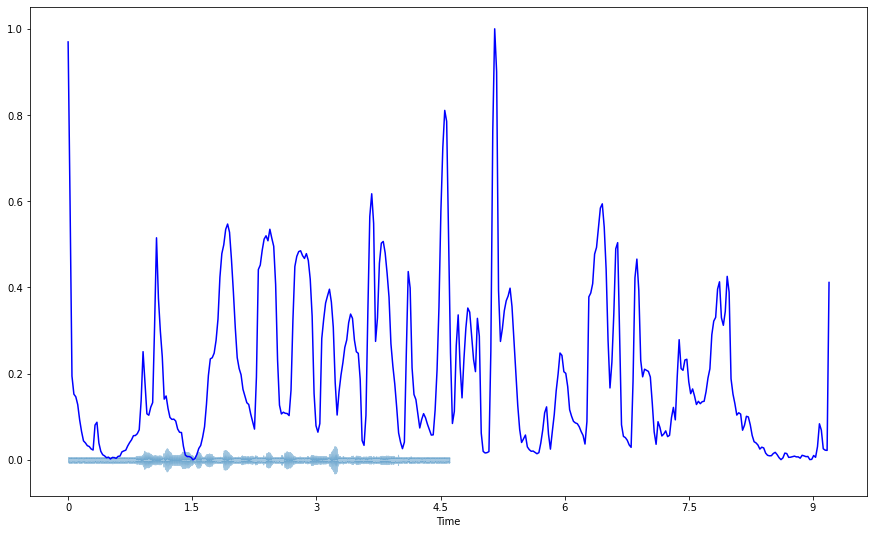

In [19]:
# # Normalising the spectral centroid for visualisation
# def normalize(x, axis=0):
#     return sklearn.preprocessing.minmax_scale(x, axis=axis)


# # Plotting the Spectral Centroid along the waveform
# plt.figure(figsize=(15, 9))
# librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
# plt.plot(t, normalize(spectral_centroids), color='b')
# plt.show()
visualizer.plot_spectral_centroid(t,spectral_centroids,samples,sample_rate)

# Plot Spectral rolloff

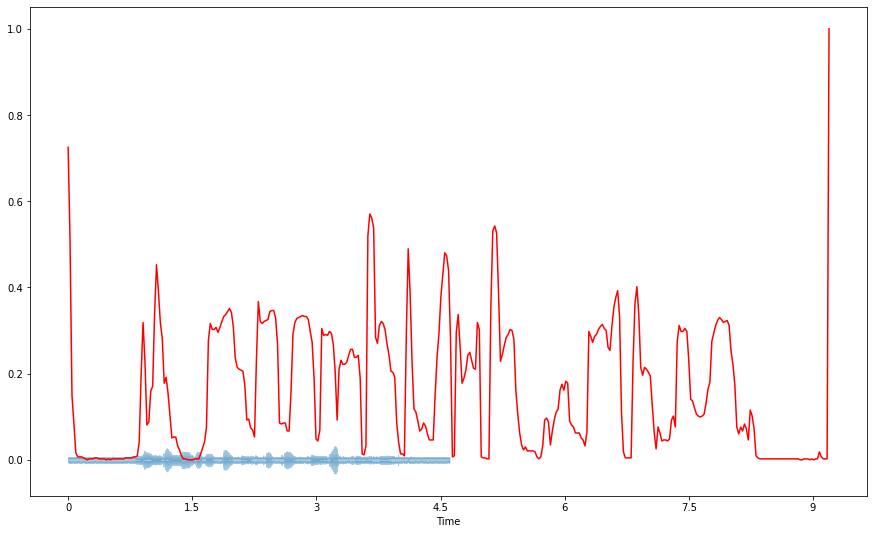

In [20]:
spectral_rolloff = librosa.feature.spectral_rolloff(
    samples+0.01, sr=sample_rate)[0]
# # print(spectral_rolloff)
# plt.figure(figsize=(15, 9))
# librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
# plt.plot(t, normalize(spectral_rolloff), color='r')
# plt.show()
visualizer.plot_spectral_rolloff(t,spectral_rolloff,samples,sample_rate)


# Plot Spectral Bandwidth

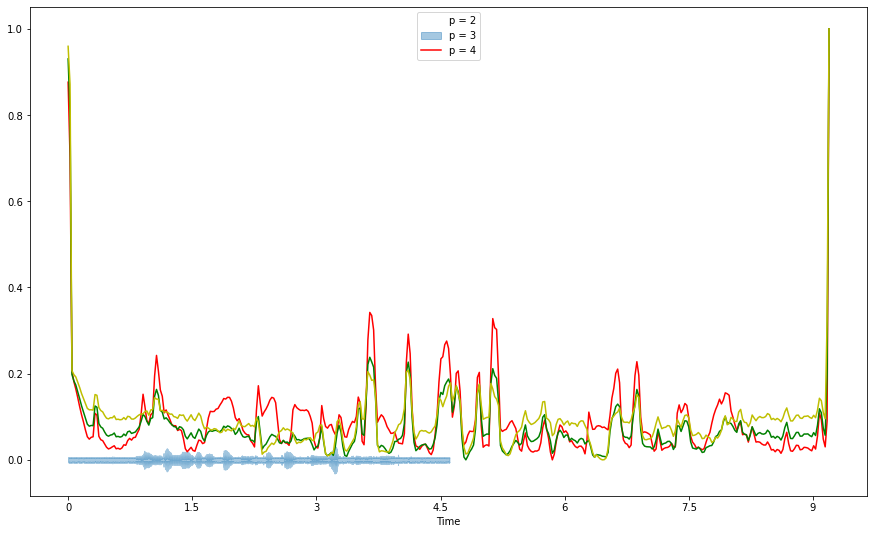

In [21]:
# spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(
#     samples+0.01, sr=sample_rate)[0]
# spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(
#     samples+0.01, sr=sample_rate, p=3)[0]
# spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(
#     samples+0.01, sr=sample_rate, p=4)[0]
# plt.figure(figsize=(15, 9))

# librosa.display.waveshow(samples, sr=sample_rate, alpha=0.4)
# plt.plot(t, normalize(spectral_bandwidth_2), color='r')
# plt.plot(t, normalize(spectral_bandwidth_3), color='g')
# plt.plot(t, normalize(spectral_bandwidth_4), color='y')
# plt.legend(('p = 2', 'p = 3', 'p = 4'))
# plt.show()
visualizer.plot_spectral_bandwidth(t,samples,sample_rate)

# Data Augmentation

# Using Time shifting
    - Plotting Spectogram along with amplitude graph for visual comparison

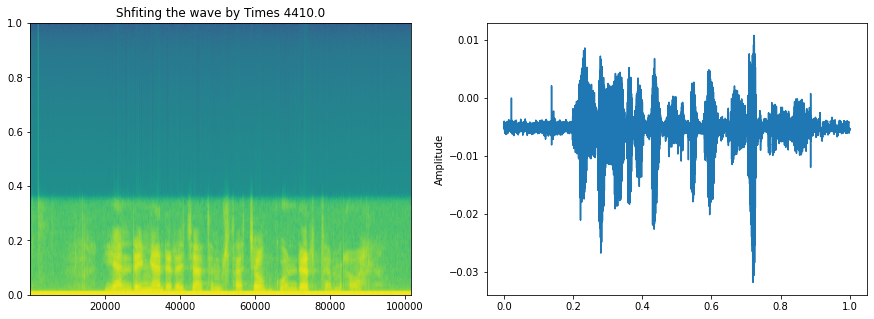

In [22]:
# def plot_spec(data: np.array, sr: int) -> None:
#     '''
#     Function for plotting spectrogram along with amplitude wave graph
#     '''

#     fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#     ax[0].title.set_text(f'Shfiting the wave by Times {sr/10}')
#     ax[0].specgram(data, Fs=2)
#     ax[1].set_ylabel('Amplitude')
#     ax[1].plot(np.linspace(0, 1, len(data)), data)
    # fig.savefig('spectogramamplitude.png')
wav_roll = np.roll(samples, int(sample_rate/10))
visualizer.plot_spec(data=wav_roll, sr=sample_rate)
# ipd.Audio(wav_roll,rate=sample_rate)

In [23]:
class AugmentAudio:
    def __init__(self) -> None:
        pass

    def add_noise(self, data: np.array, noise_factor: float) -> np.array:
        noise = np.random.randn(len(data))
        augmented_data = data + noise_factor * noise
        augmented_data = augmented_data.astype(type(data[0]))

        return augmented_data

    def add_time_shift(self,
                       data: np.array,
                       sampling_rate: int,
                       shift_max: float,
                       shift_direction: str) -> np.array:
        shift = np.random.randint(sampling_rate * shift_max)
        if shift_direction == 'right':
            shift = -shift
        elif shift_direction == 'both':
            direction = np.random.randint(0, 2)
            if direction == 1:
                shift = -shift
        augmented_data = np.roll(data, shift)
        if shift > 0:
            augmented_data[:shift] = 0
        else:
            augmented_data[shift:] = 0

        return augmented_data
    
    def change_pitch(self, data, sampling_rate, pitch_factor):
        return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

    def change_speed(self, data, speed_factor):
        return librosa.effects.time_stretch(data, speed_factor)
# audio_augmenter = AugmentAudio()

# Adding noise into the audio

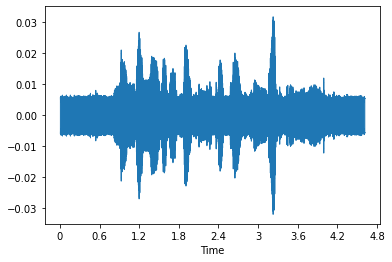

In [24]:

noise_added = augment.add_noise(samples, noise_factor=0.0001)
librosa.display.waveshow(noise_added, sr=sample_rate)
Audio(data=noise_added, rate=sample_rate)

# using time shift by sample_rate/5 factor

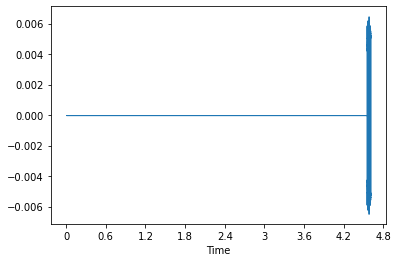

In [25]:
time_shifted = augment.add_time_shift(samples, sample_rate, 5, 'both')
librosa.display.waveshow(time_shifted, sr=sample_rate)
Audio(data=time_shifted, rate=sample_rate)

# using pitch shift

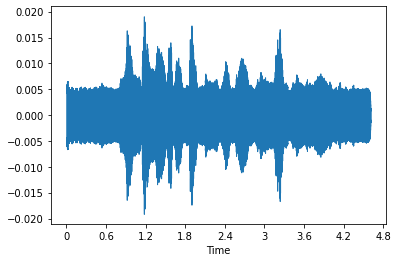

In [26]:
pitch_shifted = augment.change_pitch(samples, sample_rate, pitch_factor=0.1)
librosa.display.waveshow(pitch_shifted, sr=sample_rate)
Audio(data=pitch_shifted, rate=sample_rate)

# Feature Extraction from Audios

# Plot Mel-Frequency Cepstral Coefficients(MFCCs)

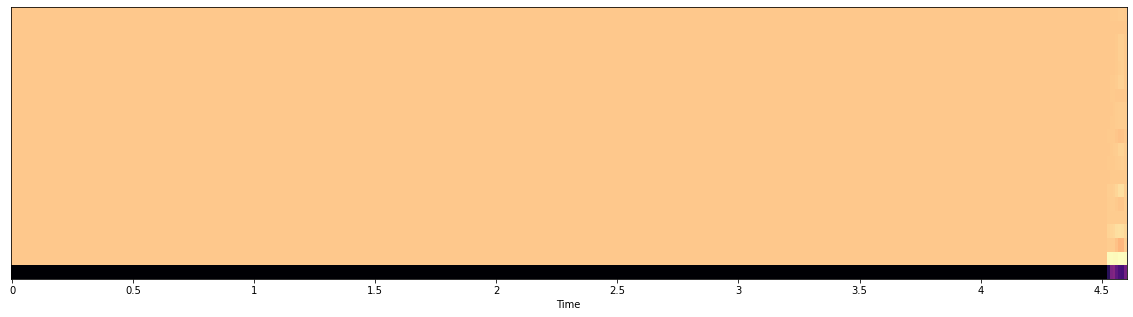

In [27]:
# plt.figure(figsize=(20, 5))
# mfccs = librosa.feature.mfcc(time_shifted, sr=sample_rate)
# librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
# print(mfccs.shape)
visualizer.plot_mfcc(time_shifted,sample_rate)

In [28]:
# def meta_data(trans, path):
#     target = []
#     features = []
#     mode=[]
#     rmse=[]
#     spec_cent=[]
#     spec_bw=[]
#     rolloff=[]
#     zcr=[]
#     mfcc=[]
#     rate=[]
#     filenames = []
#     duration_of_recordings = []
#     for index, k in enumerate(trans):
#         if index < 5:
#             filename = path + k + ".wav"
#             next_file_name = path + k + "changed.wav"
#             if exists(filename):
#                 # stereo = make_stereo(filename, next_file_name)
#                 filenames.append(filename)
#                 audio, fs = librosa.load(filename, sr=44100)
#                 chroma_stft = librosa.feature.chroma_stft(y = audio, sr = fs)
#                 rmse.append(np.mean(librosa.feature.rms(y = audio)))
#                 spec_cent.append(np.mean(librosa.feature.spectral_centroid(y = audio, sr = fs)))
#                 spec_bw.append(np.mean(librosa.feature.spectral_bandwidth(y = audio, sr = fs)))
#                 rolloff.append(np.mean(librosa.feature.spectral_rolloff(y = audio, sr = fs)))
#                 zcr.append(np.mean(librosa.feature.zero_crossing_rate(audio)))
#                 mfcc.append(np.mean(librosa.feature.mfcc(y = audio, sr = fs)))
#                 duration_of_recordings.append(float(len(audio)/fs))
#                 rate.append(fs)
#                 mode.append('mono') # if stereo == 1 else 'stereo')
#                 lable = trans[k]
#                 target.append(lable)
#     return filenames, target, duration_of_recordings,mode,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc,rate


# Create Dataframe with extracted data and save to file

In [29]:
filenames, target, duration_of_recordings,mode ,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc,rate = loader.meta_data(transcription, train_wav_location)
data = pd.DataFrame({'key': filenames, 'text': target,
                    'duration': duration_of_recordings, 'mode': mode , 'rate': rate ,'rmse': rmse,'spec_cent' :spec_cent,'spec_bw': spec_bw,"rolloff" :rolloff,"zcr": zcr,"mfcc": mfcc})
data.head()
# print(data.shape)

,key,text,duration,mode,rate,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc
0,train/wav/tr_1_tr01001.wav,ያንደኛ ደረጃ ትምህርታቸው ን ጐንደር ተ ም ረዋል,4.608005,mono,44100,0.005627,713.781516,1236.804586,1485.248618,0.004273,-18.103716
1,train/wav/tr_2_tr01002.wav,የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስ...,16.384014,mono,44100,0.005557,769.171143,1256.989803,1618.360516,0.003095,-17.840212
2,train/wav/tr_3_tr01003.wav,በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ...,14.592018,mono,44100,0.005417,783.725021,1286.675508,1654.442077,0.001926,-18.258934
3,train/wav/tr_4_tr01004.wav,ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው,4.736009,mono,44100,0.005535,687.372255,1161.387180,1368.097283,0.004953,-18.796532
4,train/wav/tr_5_tr01005.wav,ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳ...,8.192018,mono,44100,0.005626,782.274709,1257.456211,1691.149453,0.003393,-18.172558


In [42]:
md_json = data.to_dict(orient='records')
with open("train_corpus.json", "w", encoding='UTF-8') as export_file:
            json.dump(md_json, export_file, indent=4,
                     sort_keys=True, ensure_ascii=False)


['train/wav/tr_1_tr01001.wav', 'train/wav/tr_2_tr01002.wav', 'train/wav/tr_3_tr01003.wav', 'train/wav/tr_4_tr01004.wav', 'train/wav/tr_5_tr01005.wav']
